#### This kernel adopted from
https://www.kaggle.com/elenapetrova/time-series-analysis-and-forecasts-with-prophet

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet

%matplotlib inline

In [82]:
train_data = pd.read_csv('data/train.csv', index_col='Date', low_memory=False, parse_dates=True)
store_data = pd.read_csv('data/store.csv', low_memory=False)

In [83]:
train_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [84]:
store_data.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


### Explore train

In [85]:
train_data['Year'] = train_data.index.year
train_data['Month'] = train_data.index.month
train_data['Day'] = train_data.index.day
train_data['WeekOfYear'] = train_data.index.weekofyear

In [86]:
train_data['SalePerCustomer'] = train_data['Sales']/train_data['Customers']
train_data['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

In [87]:
print("In total: ", train_data.shape)
train_data.head(5)

In total:  (1017209, 13)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31,9.702400
2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31,10.126675
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31,9.342457
2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31,8.626118


Store - a unique Id for each store <br>
Sales - the turnover for any given day (this is what you are predicting) <br>
Customers - the number of customers on a given day <br>
Open - an indicator for whether the store was open: 0 = closed, 1 = open <br>
Promo - indicates whether a store is running a promo on that day <br>
StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None <br>
SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools <br>

In [88]:
train_data.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,844340.000000
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01,2.013832e+03,5.846762e+00,1.570279e+01,2.361551e+01,9.493619
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01,7.773960e-01,3.326097e+00,8.787638e+00,1.443338e+01,2.197494
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.013000e+03,1.000000e+00,1.000000e+00,1.000000e+00,0.000000
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,2.013000e+03,3.000000e+00,8.000000e+00,1.100000e+01,7.895563
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,2.014000e+03,6.000000e+00,1.600000e+01,2.200000e+01,9.250000
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,2.014000e+03,8.000000e+00,2.300000e+01,3.500000e+01,10.899729
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,2.015000e+03,1.200000e+01,3.100000e+01,5.200000e+01,64.957854


### Insights
- The average spending for each customer per day is 9.49 (with SD = 2.19). 
- Interestingly, the minimum sales is 0, meaning there are some days where the stores could not sell anything or not operating.
- The maximum average spending per customer is surprisingly high at almost 65. We will need to have a closer look into this record.

In [89]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 13 columns):
Store              1017209 non-null int64
DayOfWeek          1017209 non-null int64
Sales              1017209 non-null int64
Customers          1017209 non-null int64
Open               1017209 non-null int64
Promo              1017209 non-null int64
StateHoliday       1017209 non-null object
SchoolHoliday      1017209 non-null int64
Year               1017209 non-null int64
Month              1017209 non-null int64
Day                1017209 non-null int64
WeekOfYear         1017209 non-null int64
SalePerCustomer    844340 non-null float64
dtypes: float64(1), int64(11), object(1)
memory usage: 128.6+ MB


SalePerCustomer has fewer number of rows, this should be due to Customers in that row equal to 0. Let's find out

In [90]:
print((train_data['Customers'] == 0).sum())
(train_data['Customers'] == 0).sum() + 844340

172869


1017209

Yes, the aussumption is correct

### checking salepercustomer

In [91]:
train_data[train_data['SalePerCustomer'] > 50]

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2013-10-24,126,4,33071,574,1,1,0,1,2013,10,24,43,57.614983
2013-10-22,126,2,30619,554,1,1,0,1,2013,10,22,43,55.268953
2013-10-19,897,6,16558,331,1,0,0,0,2013,10,19,42,50.024169
2013-10-14,126,1,25049,475,1,0,0,0,2013,10,14,42,52.734737
2013-09-17,897,2,11166,216,1,0,0,0,2013,9,17,38,51.694444
2013-09-02,897,1,16954,261,1,0,0,0,2013,9,2,36,64.957854
2013-05-08,897,3,17148,319,1,0,0,0,2013,5,8,19,53.755486


### ECDF: empirical cumulative distribution function

Text(0.5,0,'Sale per Customer')

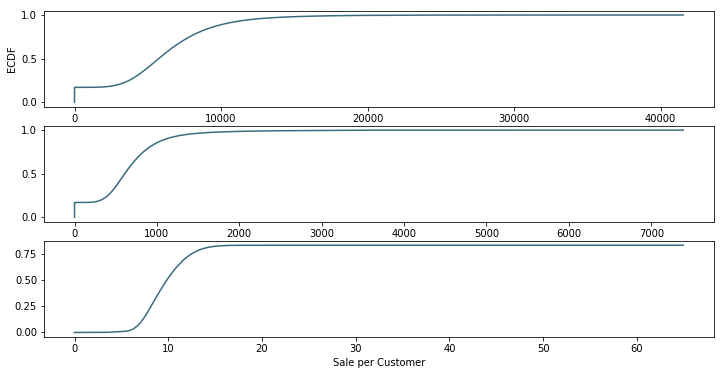

In [92]:
c = '#386B7F'
plt.figure(figsize=(12,6))

plt.subplot(311)
cdf = ECDF(train_data['Sales'])
plt.plot(cdf.x, cdf.y, label='statmodels', color=c)
plt.xlabel('Sales')
plt.ylabel('ECDF')

plt.subplot(312)
cdf = ECDF(train_data['Customers'])
plt.plot(cdf.x, cdf.y, label='statmodels', color=c)
plt.xlabel('Customers')

plt.subplot(313)
cdf = ECDF(train_data['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label='statmodels', color=c)
plt.xlabel('Sale per Customer')

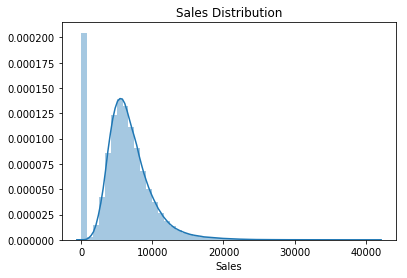

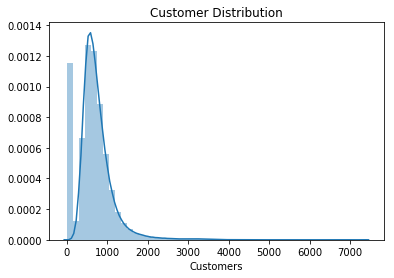

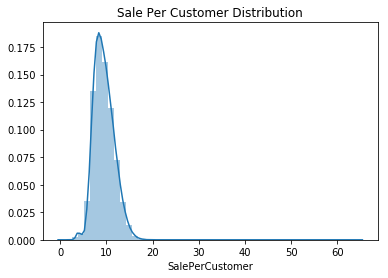

In [93]:
sns.distplot(train_data['Sales']);
plt.title('Sales Distribution')
plt.show()
sns.distplot(train_data['Customers']);
plt.title('Customer Distribution')
plt.show()
sns.distplot(train_data.loc[train_data['SalePerCustomer'].notnull(), 'SalePerCustomer']);
plt.title('Sale Per Customer Distribution')
plt.show()

According to the distributions, around 20% of the sales records are 0 and inconsistantly almost 12% of the records are 0. This means that there are records that have customers with no sale at all.

In [94]:
train_data[(train_data['Sales']<=0) & (train_data['Customers']>0)]

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2014-04-29,1100,2,0,3,1,1,0,0,2014,4,29,18,0.0
2013-04-25,948,4,0,5,1,1,0,0,2013,4,25,17,0.0


#### Missing value

In [95]:
print(train_data[(train_data.Open==0) & (train_data.Sales==0)].shape)
train_data[(train_data.Open==0) & (train_data.Sales==0)].head()

(172817, 13)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-31,876,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-30,292,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-30,876,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-29,292,3,0,0,0,1,0,1,2015,7,29,31,NaN


There are 172,817 rows for closed store data. We will have to remove these rows to prevent the model bias towards the 0 sale prediction.

In [96]:
zero_sales = train_data[(train_data.Open != 0) & (train_data.Sales == 0)]
print('In total: ', zero_sales.shape)
zero_sales.head(5)

In total:  (54, 13)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-05-15,971,5,0,0,1,0,0,1,2015,5,15,20,NaN
2015-03-26,674,4,0,0,1,0,0,0,2015,3,26,13,NaN
2015-02-05,699,4,0,0,1,1,0,0,2015,2,5,6,NaN
2014-10-01,708,3,0,0,1,1,0,0,2014,10,1,40,NaN
2014-09-22,357,1,0,0,1,0,0,0,2014,9,22,39,NaN


There are the records that open==1 but the sales = 0, meaning no sale on working days. We will remove this data as well.

In [97]:
train_data = train_data[(train_data['Open'] != 0) & (train_data['Sales'] != 0)]
train_data.shape

(844338, 13)

## Explore Store

In [98]:
store_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


StoreType - differentiates between 4 different store models: a, b, c, d <br>
Assortment - describes an assortment level: a = basic, b = extra, c = extended <br>
CompetitionDistance - distance in meters to the nearest competitor store <br>
CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened <br>
Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating <br>
Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2 <br>
PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store <br>

In [99]:
store_data.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [100]:
store_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [101]:
store_data.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

We need to handle with the missing values shown.

#### Dealing with Missing Value for CompetitionDistance

In [102]:
store_data[pd.isnull(store_data.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


mean:  5404.901079136691
median:  2325.0


Text(0.5,1,'Competition Distance')

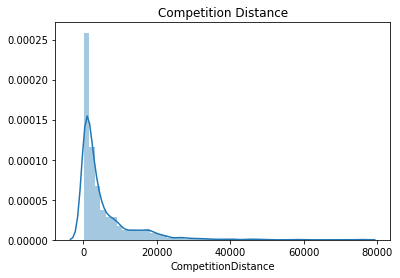

In [103]:
print('mean: ', store_data.CompetitionDistance.mean())
print('median: ', store_data.CompetitionDistance.median())
sns.distplot(store_data.loc[store_data.CompetitionDistance.notnull(), 'CompetitionDistance'])
plt.title('Competition Distance')

Since there are some outliers which make the distribution become positive skew, it makes sense to use median for the missing values.

In [104]:
store_data['CompetitionDistance'].fillna(store_data['CompetitionDistance'].median(), inplace=True)

In [105]:
store_data[pd.isnull(store_data.Promo2SinceWeek) & (store_data.Promo2 != 0)].shape

(0, 10)

In [106]:
store_data.fillna(0, inplace=True)

Promo2sinceWeek/year/interval are Nan when there is no promotion so it makes sense to replace NAN with 0 to mean that there is no promotion.

### Merging the 2 dataset

In [107]:
train_store = pd.merge(train_data, store_data, how='inner', on='Store')
print('In total: ', train_store.shape)
train_store.head()

In total:  (844338, 22)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


### Analyze by Store Type

In [108]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


In [109]:
train_store.groupby('StoreType')['SalePerCustomer'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,8.846296,1.690913,3.635389,7.611945,8.631363,9.899438,29.877551
b,15560.0,5.133427,1.253988,2.749075,4.039561,4.987022,6.108760,9.203528
c,112968.0,8.626227,1.694325,3.382542,7.416985,8.424736,9.643063,64.957854
d,258768.0,11.277862,1.990706,4.881279,9.873309,11.194977,12.560328,57.614983


In [110]:
train_store.groupby('StoreType')['Customers', 'Sales'].sum()

,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


In [111]:
train_store.groupby('StoreType')['Store'].nunique()

StoreType
a    602
b     17
c    148
d    348
Name: Store, dtype: int64

- The average sales per day of type B is the highest. However, its sales per customer is the lowest and also the total sales and total customers are the loweest. The high sale per day may due to the fact that type B has only 17 stores and the customers have fewer store options to visit.
- The type which has highest sales is A. This is due to the highest number of stores.

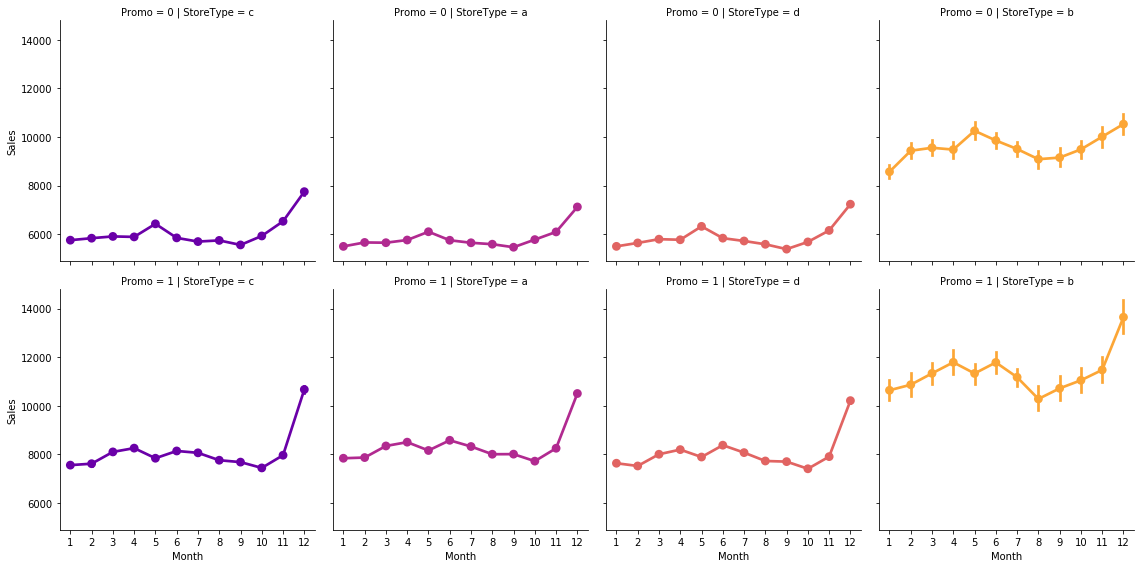

In [112]:
sns.factorplot(data=train_store, x='Month', y='Sales',
               col='StoreType',
               palette='plasma',
               hue='StoreType',
               row='Promo',
               color=c)

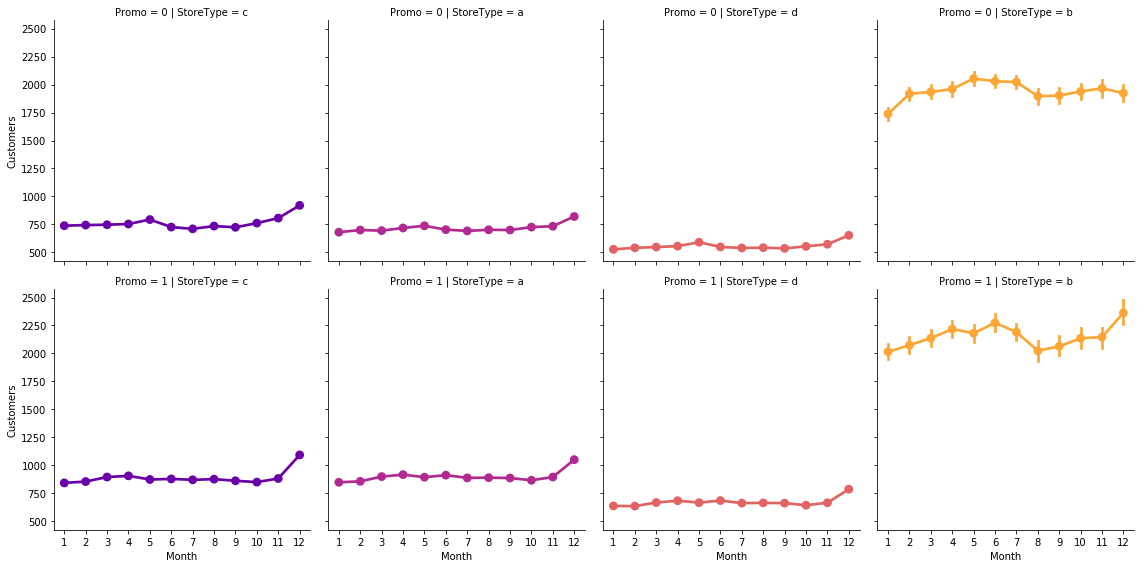

In [113]:
sns.factorplot(data=train_store, x='Month', y='Customers',
               col='StoreType',
               palette='plasma',
               hue='StoreType',
               row='Promo',
               color=c)

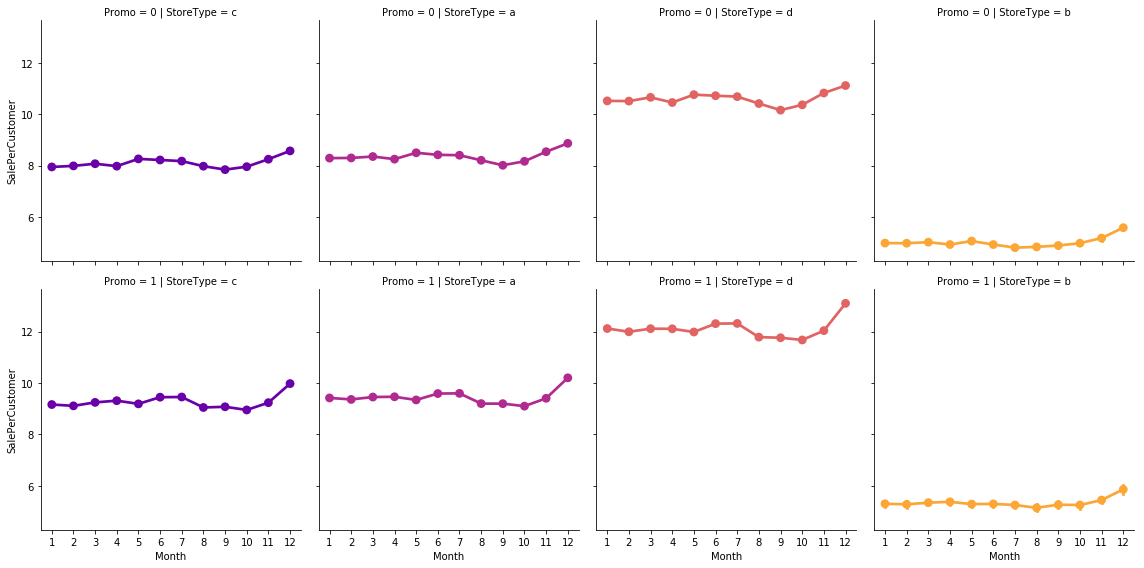

In [114]:
sns.factorplot(data=train_store, x='Month', y='SalePerCustomer',
               col='StoreType',
               palette='plasma',
               hue='StoreType',
               row='Promo',
               color=c)

- As we can see, the number of sales increases towards the end of the year for all the store types while the number of customers increases just slightly, meaning people tend to spend more on the end of the year.
- For A, B, C stores, promotions tend to have significant impact on the sales but no obvious impact on type D.

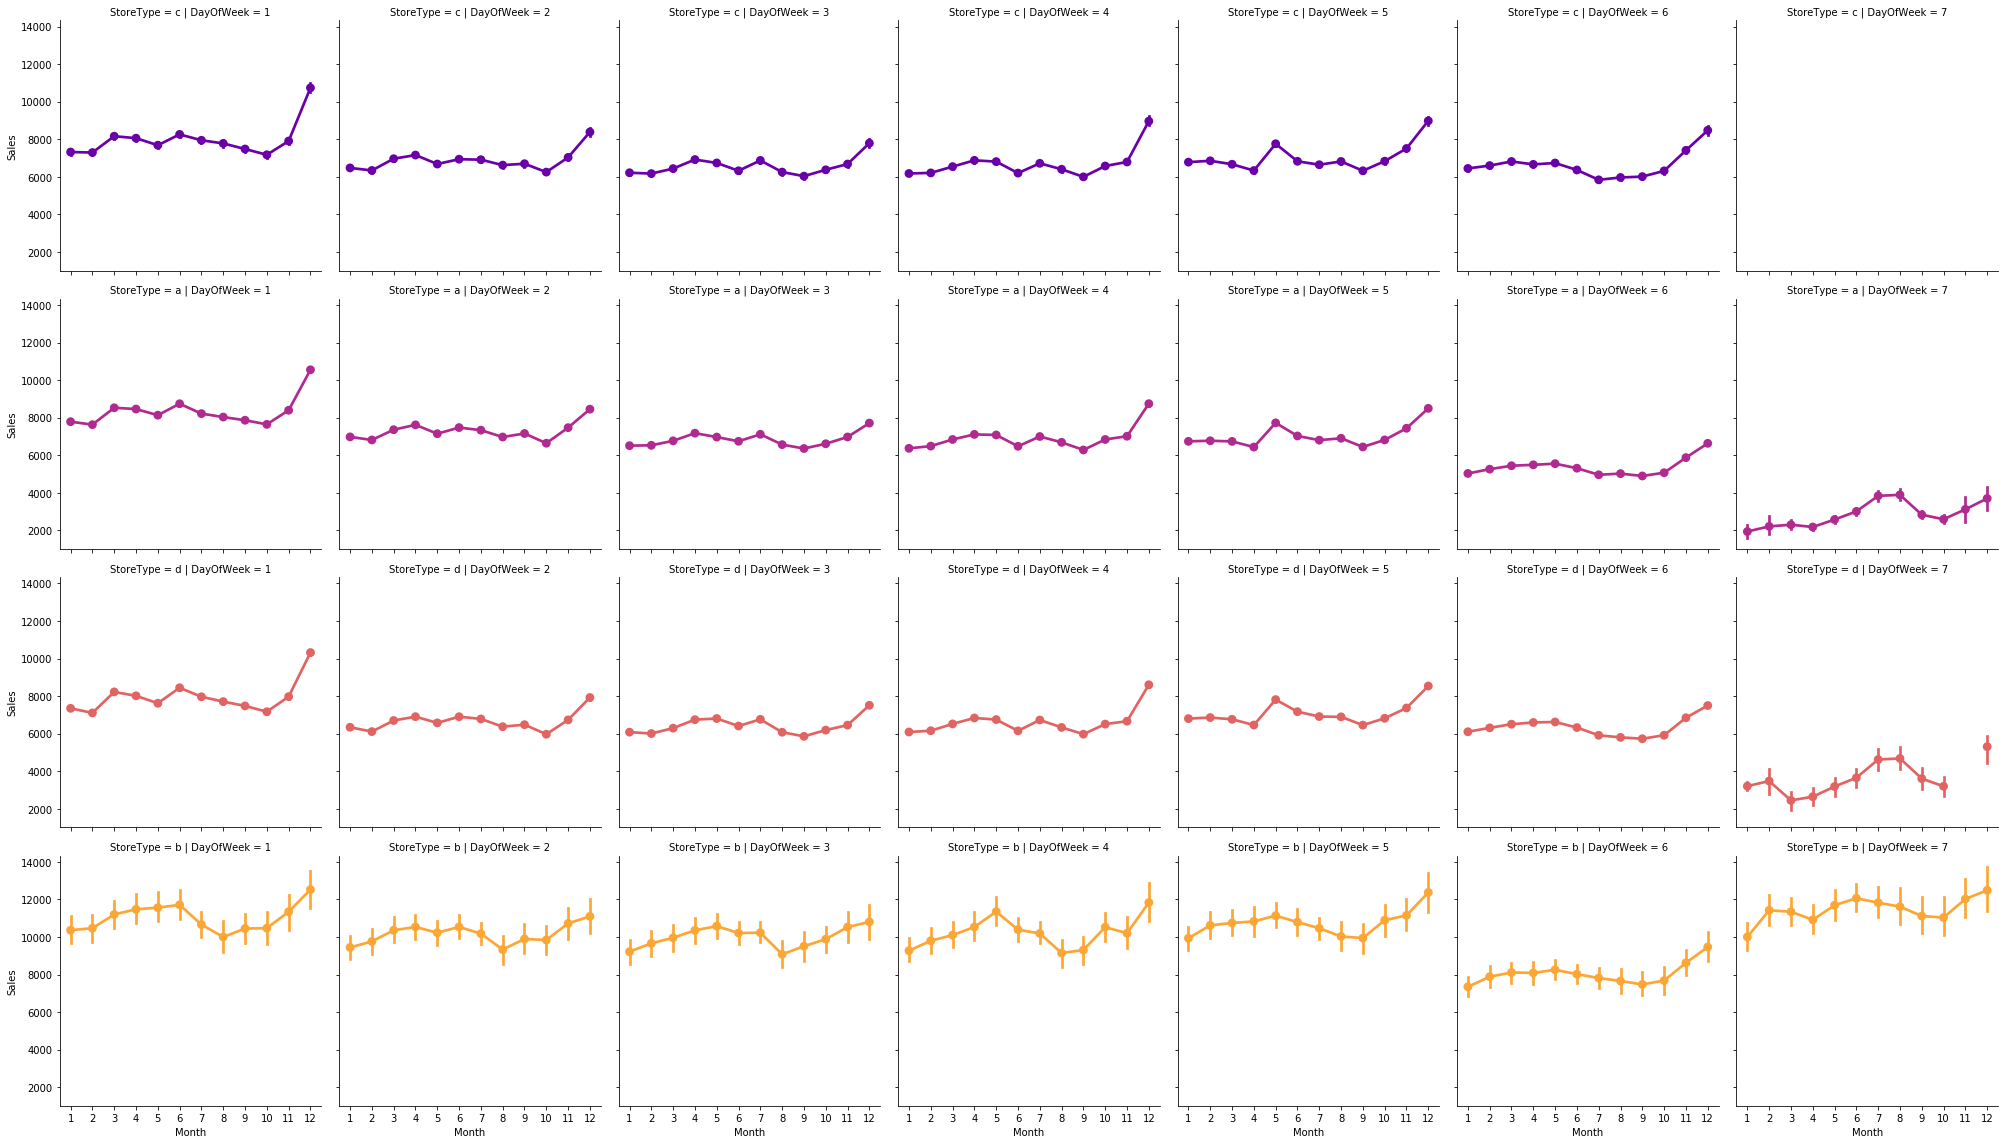

In [115]:
sns.factorplot(data=train_store, x='Month', y='Sales',
               col='DayOfWeek',
               palette='plasma',
               hue='StoreType',
               row='StoreType',
               color=c)

- When analyzing the impact of the days of week, all of the stores have downward trend from Monday to Friday and have substantial drop on the weekend. Also, store type C is not operating on Sunday.

In [116]:
train_store[(train_store.Open == 1) & (train_store.DayOfWeek == 7)]['Store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  877,  931,  948, 1045, 1081, 1097, 1099])

List of the stores open on Sunday

In [117]:
train_store['CompetitionOpen'] = 12*(train_store.Year-train_store.CompetitionOpenSinceYear) + \
    (train_store.Month - train_store.CompetitionOpenSinceMonth)

train_store['PromoOpen'] = 12*(train_store.Year-train_store.Promo2SinceYear)+\
    (train_store.WeekOfYear-train_store.Promo2SinceWeek)/4.0

train_store.fillna(0, inplace=True)
train_store.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen',
                    'CompetitionOpen']].groupby('StoreType').mean()

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
a,6925.697986,795.422370,12918.492198,7115.514452
b,10233.380141,2022.211825,17199.328069,11364.495244
c,6933.126425,815.538073,12158.636107,6745.418694
d,6822.300064,606.353935,10421.916846,9028.526526


- Store type B has the highest sales and customers per day due to the fact that it is running promotion longest eventhough it is exposed to more competition.
- Store type D, although running shortest promotion, has quite high sales (from previous analysis).

#### Correlational Analysis

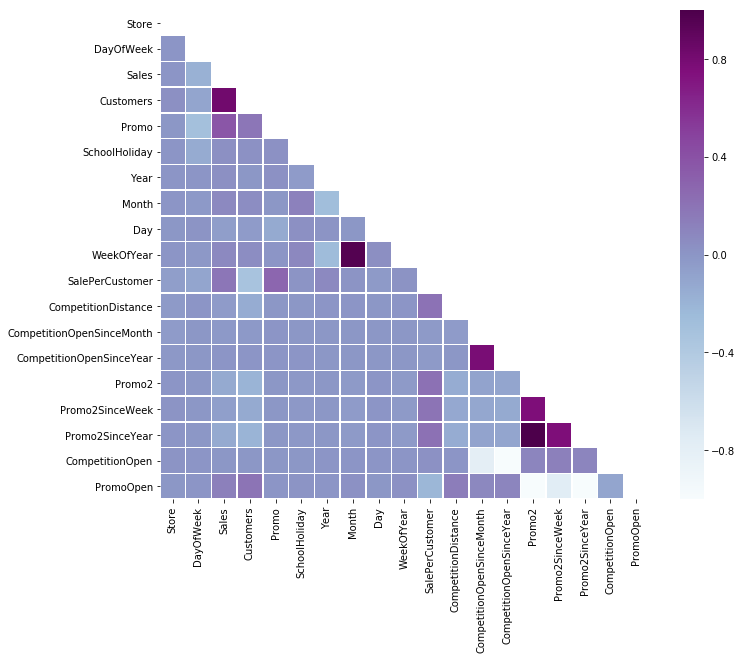

In [118]:
corr_all = train_store.drop('Open', axis=1).corr()

mask = np.zeros_like(corr_all, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11,9))

sns.heatmap(corr_all, mask=mask, square=True, linewidths=.5,
            ax=ax, cmap='BuPu')

plt.show()

- As the previous analysis, Sales has high correlation to the Customers and Promo. However, Promo2 has negative correlation with the Sales. So the company should think carefully before running the Promo2.
- Competition seems not to have that much effect on the Sales. This may due to better transportation nowadays.

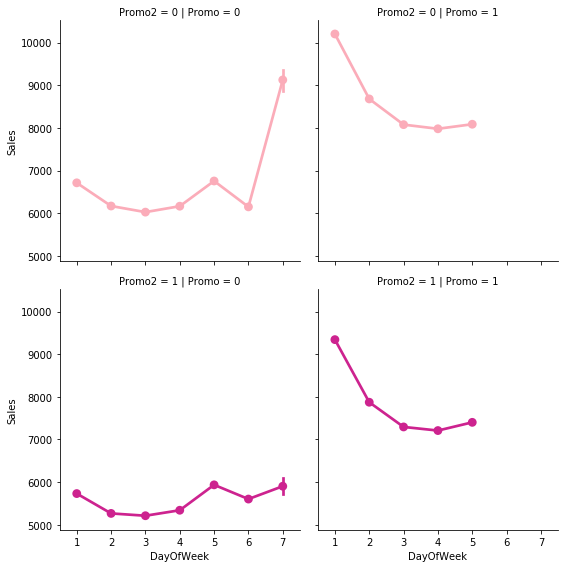

In [119]:
sns.factorplot(data=train_store, x='DayOfWeek', y='Sales',
               col='Promo',
               row='Promo2',
               hue='Promo2',
               palette='RdPu')

## Time series Analysis

#### Selected stores

For the ease of presentation, I will select 1 store for each store type to do Time series Analysis

In [120]:
train_data['Sales'] = train_data['Sales'] * 1.0

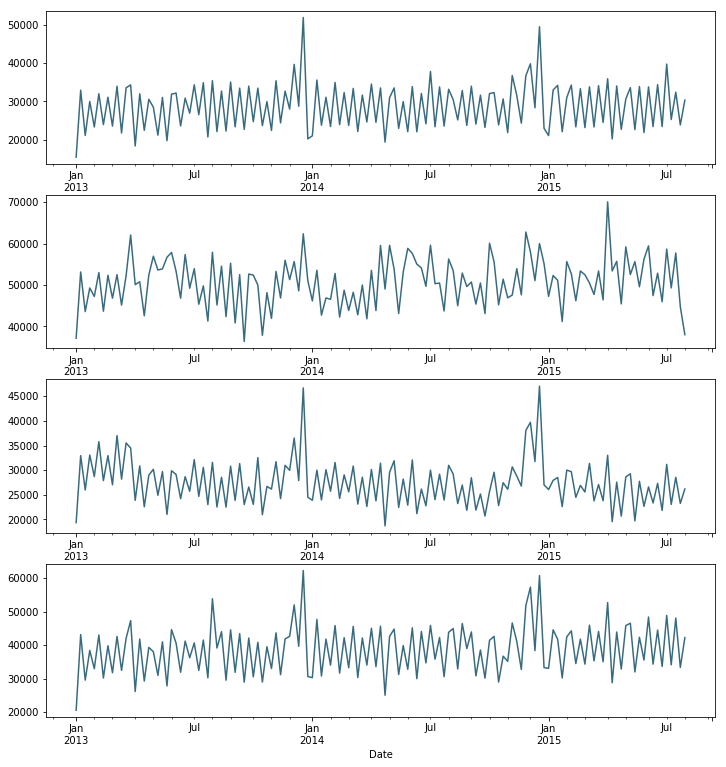

In [223]:
# preparation: input should be float type
train_data['Sales'] = train_data['Sales'] * 1.0

# store types
sales_a = train_data[train_data.Store == 2]['Sales']
sales_b = train_data[train_data.Store == 85]['Sales'].sort_index(ascending = True) # solve the reverse order
sales_c = train_data[train_data.Store == 1]['Sales']
sales_d = train_data[train_data.Store == 15]['Sales']

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# store types
sales_a.resample('W').sum().plot(color = c, ax = ax1)
sales_b.resample('W').sum().plot(color = c, ax = ax2)
sales_c.resample('W').sum().plot(color = c, ax = ax3)
sales_d.resample('W').sum().plot(color = c, ax = ax4)

- Store type A and C have sudden peaks around December every year.

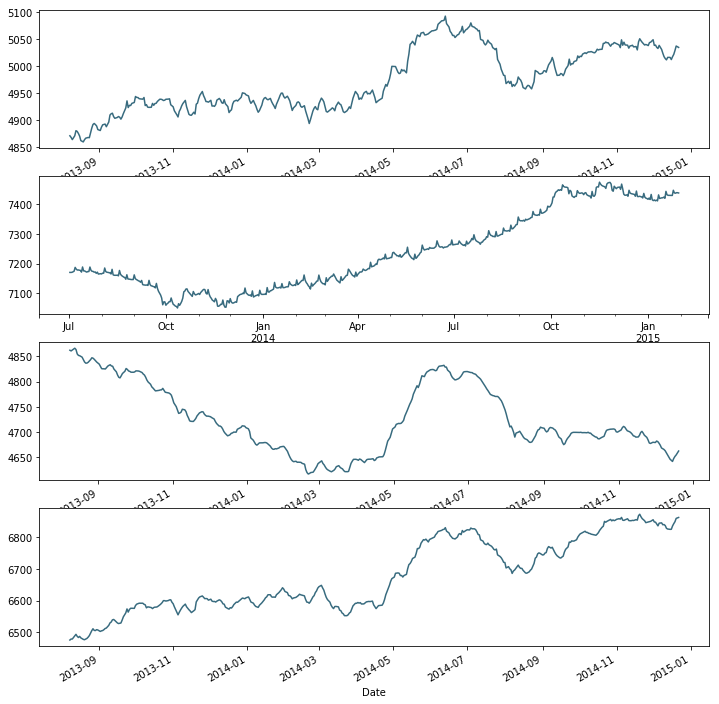

In [224]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(12,13))

decomposition_a = seasonal_decompose(sales_a, model='additive', freq=365)
decomposition_a.trend.plot(color=c, ax=ax1)

decomposition_b = seasonal_decompose(sales_b, model='additive', freq=365)
decomposition_b.trend.plot(color=c, ax=ax2)

decomposition_c = seasonal_decompose(sales_c, model='additive', freq=365)
decomposition_c.trend.plot(color=c, ax=ax3)

decomposition_d = seasonal_decompose(sales_d, model='additive', freq=365)
decomposition_d.trend.plot(color=c, ax=ax4)

The trends of store type A, B, D are upwards while that of store type C is downwards.

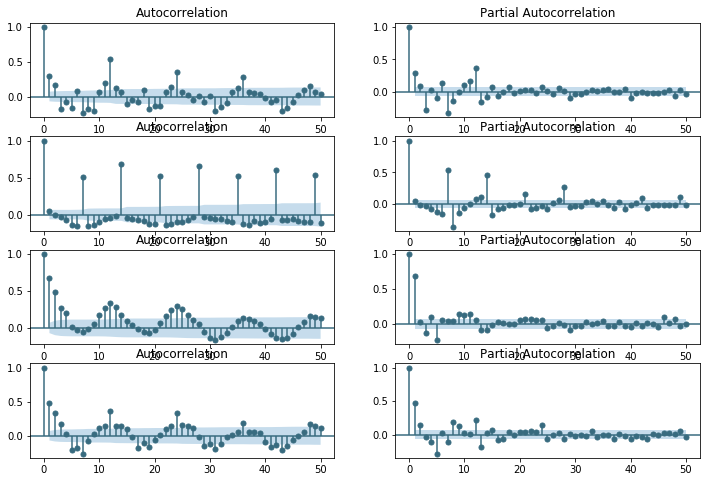

In [225]:
plt.figure(figsize=(12,8))

plt.subplot(421); plot_acf(sales_a, lags=50, ax=plt.gca(), color=c)
plt.subplot(422); plot_pacf(sales_a, lags=50, ax=plt.gca(), color=c)

plt.subplot(423); plot_acf(sales_b, lags=50, ax=plt.gca(), color=c)
plt.subplot(424); plot_pacf(sales_b, lags=50, ax=plt.gca(), color=c)

plt.subplot(425); plot_acf(sales_c, lags=50, ax=plt.gca(), color=c)
plt.subplot(426); plot_pacf(sales_c, lags=50, ax=plt.gca(), color=c)

plt.subplot(427); plot_acf(sales_d, lags=50, ax=plt.gca(), color=c)
plt.subplot(428); plot_pacf(sales_d, lags=50, ax=plt.gca(), color=c)

plt.show()

- Store type A has high correlation pattern at 12X eg 12th, 24th, 36th.
- Store type B has high correlation every 7 days or weekly seasonality
- Store type C and D are more complex and they are correlated to their adjacent points.

### Using Prophet

- Select Store 2, 85, 1, 15 to represent type A, B, C, D respectively.
- We will use the last month in the dataset to be the test set, which is July 2015.

In [251]:
STORE_IDS = [2, 85, 1, 15]

df = pd.read_csv("data/train.csv", low_memory = False)
df = df[df.Store.isin(STORE_IDS)].rename(columns={'Date': 'ds', 'Sales': 'y'})
df['ds'] = pd.DatetimeIndex(df['ds'])
df.sort_index(ascending=False, inplace=True)


df_train = df[df.ds < '2015-07']
df_test = df[df.ds >= '2015-07']

- Remove the records when the stores are closed and no sale from the train data to reduce bias toward 0.

In [252]:
df_train = df_train[(df_train['Open'] != 0) & (df_train['y'] != 0)]

In [256]:
sales_train_a = df_train[df_train.Store == STORE_IDS[0]].loc[:, ['ds', 'y']]
sales_test_a = df_test[df_test.Store == STORE_IDS[0]].loc[:, ['ds', 'y']]

sales_train_b = df_train[df_train.Store == STORE_IDS[1]].loc[:, ['ds', 'y']]
sales_test_b = df_test[df_test.Store == STORE_IDS[1]].loc[:, ['ds', 'y']]

sales_train_c = df_train[df_train.Store == STORE_IDS[2]].loc[:, ['ds', 'y']]
sales_test_c = df_test[df_test.Store == STORE_IDS[2]].loc[:, ['ds', 'y']]

sales_train_d = df_train[df_train.Store == STORE_IDS[3]].loc[:, ['ds', 'y']]
sales_test_d = df_test[df_test.Store == STORE_IDS[3]].loc[:, ['ds', 'y']]

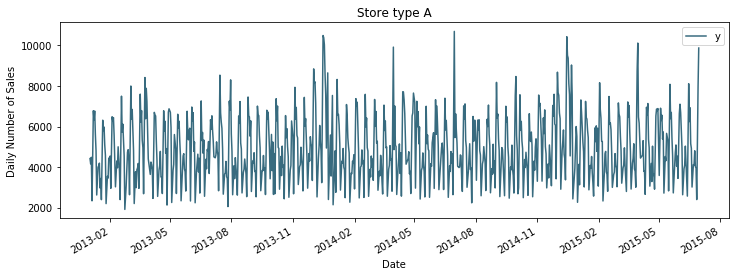

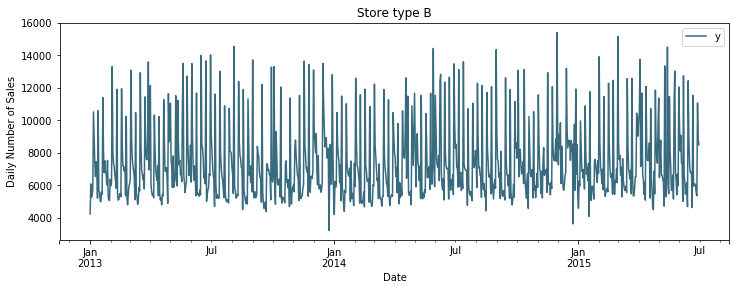

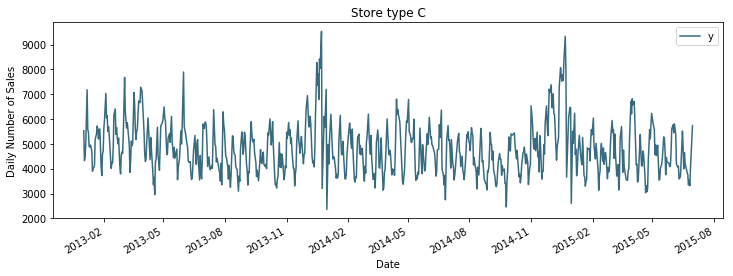

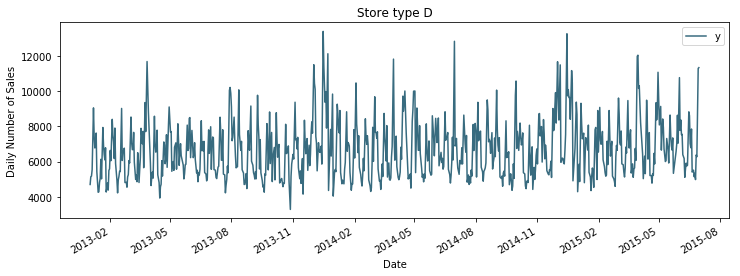

In [261]:
ax = sales_train_a.set_index('ds').plot(figsize=(12,4), color=c)
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.title('Store type A')
plt.show()

ax = sales_train_b.set_index('ds').plot(figsize=(12,4), color=c)
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.title('Store type B')
plt.show()

ax = sales_train_c.set_index('ds').plot(figsize=(12,4), color=c)
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.title('Store type C')
plt.show()

ax = sales_train_d.set_index('ds').plot(figsize=(12,4), color=c)
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.title('Store type D')
plt.show()

#### Holiday

In [264]:
state_dates = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b') & (df.StateHoliday == 'c')].loc[:, 'ds'].values
school_dates = df[df.SchoolHoliday == 1].loc[:, 'ds'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                       'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state,school))
holidays.head()

,ds,holiday
0,2013-01-01,state_holiday
1,2013-01-01,state_holiday
2,2013-01-01,state_holiday
3,2013-01-01,state_holiday
4,2013-05-01,state_holiday


In [265]:
my_model_a = Prophet(interval_width = 0.95, holidays = holidays)
my_model_b = Prophet(interval_width = 0.95, holidays = holidays)
my_model_c = Prophet(interval_width = 0.95, holidays = holidays)
my_model_d = Prophet(interval_width = 0.95, holidays = holidays)

my_model_a.fit(sales_train_a)
my_model_b.fit(sales_train_b)
my_model_c.fit(sales_train_c)
my_model_d.fit(sales_train_d)


future_dates = my_model_a.make_future_dataframe(periods=31)

print('First week to forecast.')
future_dates.tail(7)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/aiy/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


First week to forecast.


,ds
781,2015-07-25
782,2015-07-26
783,2015-07-27
784,2015-07-28
785,2015-07-29
786,2015-07-30
787,2015-07-31


In [266]:
forecast_a = my_model_a.predict(future_dates)
forecast_b = my_model_b.predict(future_dates)
forecast_c = my_model_c.predict(future_dates)
forecast_d = my_model_d.predict(future_dates)

forecast_a[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
781,2015-07-25,2544.189146,303.966989,4790.956043
782,2015-07-26,4390.331922,2257.886323,6667.253044
783,2015-07-27,6018.094741,3613.055428,8296.946544
784,2015-07-28,5265.145016,2947.505498,7351.824089
785,2015-07-29,5687.293330,3465.230700,7806.497622
786,2015-07-30,4823.845006,2725.150944,7110.002998
787,2015-07-31,4469.899499,2278.513607,6661.847993


forecast


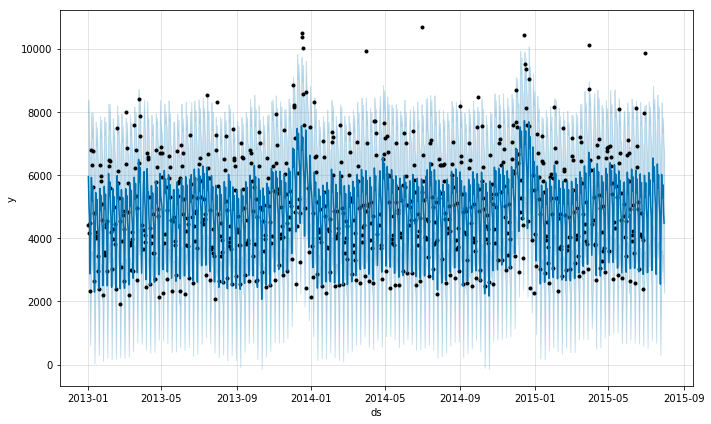

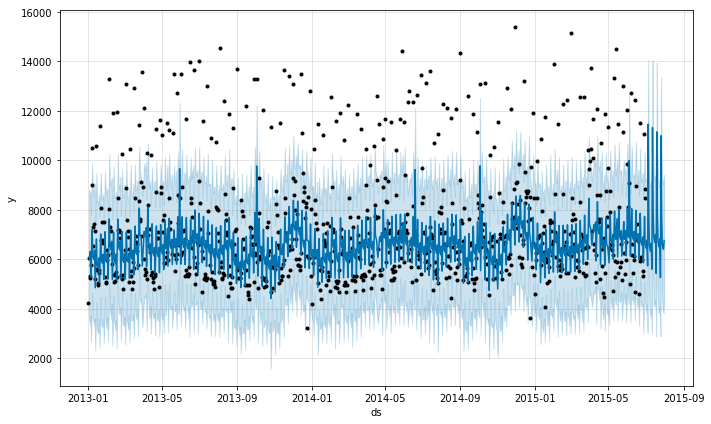

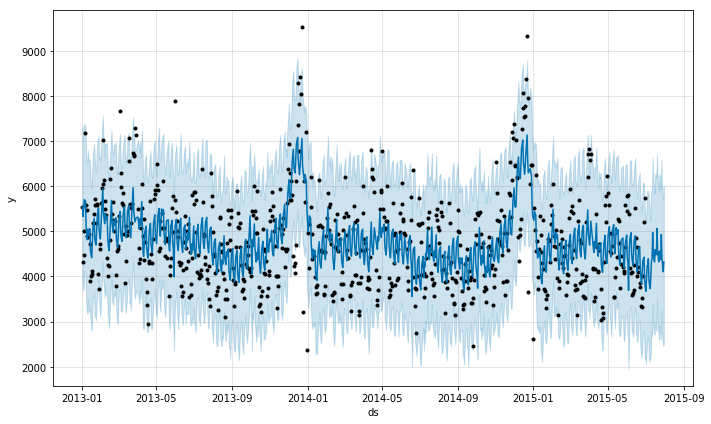

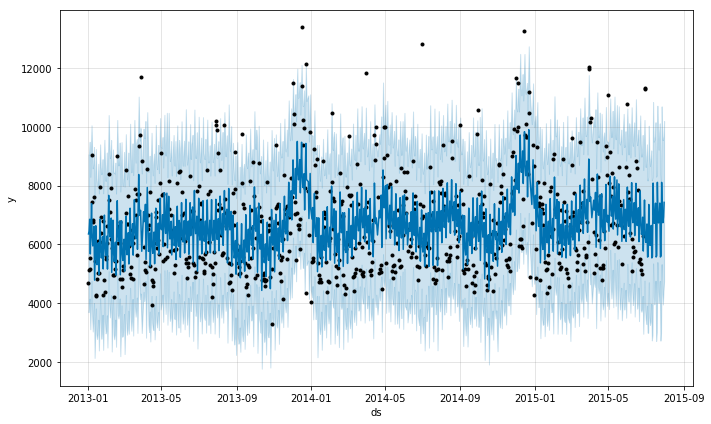

In [268]:
my_model_a.plot(forecast_a)
my_model_b.plot(forecast_b)
my_model_c.plot(forecast_c)
my_model_d.plot(forecast_d)
print('forecast')

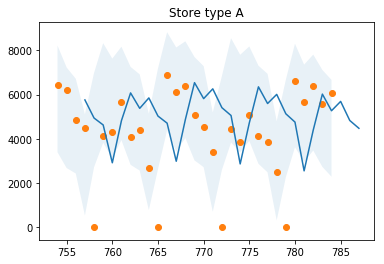

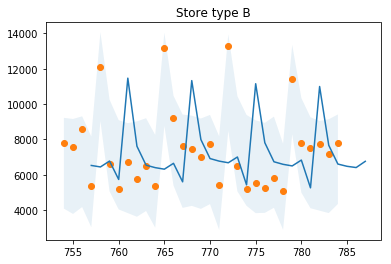

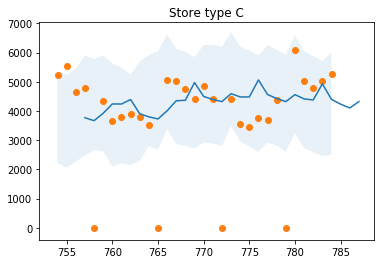

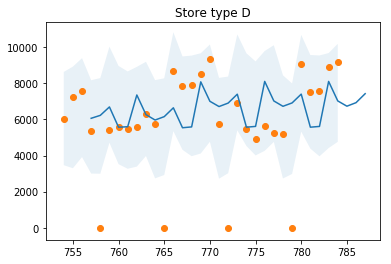

In [273]:
predicted_forecast = forecast_a[forecast_a['ds'] >= '2015-07']
plt.plot(predicted_forecast['yhat'])
plt.fill_between(range(754,785),predicted_forecast['yhat_lower'],predicted_forecast['yhat_upper'],alpha=.1)
plt.scatter(range(754,785), sales_test_a['y'])
plt.title('Store type A')
plt.show()

predicted_forecast = forecast_b[forecast_a['ds'] >= '2015-07']
plt.plot(predicted_forecast['yhat'])
plt.fill_between(range(754,785),predicted_forecast['yhat_lower'],predicted_forecast['yhat_upper'],alpha=.1)
plt.scatter(range(754,785), sales_test_b['y'])
plt.title('Store type B')
plt.show()

predicted_forecast = forecast_c[forecast_a['ds'] >= '2015-07']
plt.plot(predicted_forecast['yhat'])
plt.fill_between(range(754,785),predicted_forecast['yhat_lower'],predicted_forecast['yhat_upper'],alpha=.1)
plt.scatter(range(754,785), sales_test_c['y'])
plt.title('Store type C')
plt.show()

predicted_forecast = forecast_d[forecast_a['ds'] >= '2015-07']
plt.plot(predicted_forecast['yhat'])
plt.fill_between(range(754,785),predicted_forecast['yhat_lower'],predicted_forecast['yhat_upper'],alpha=.1)
plt.scatter(range(754,785), sales_test_d['y'])
plt.title('Store type D')
plt.show()

Component plot


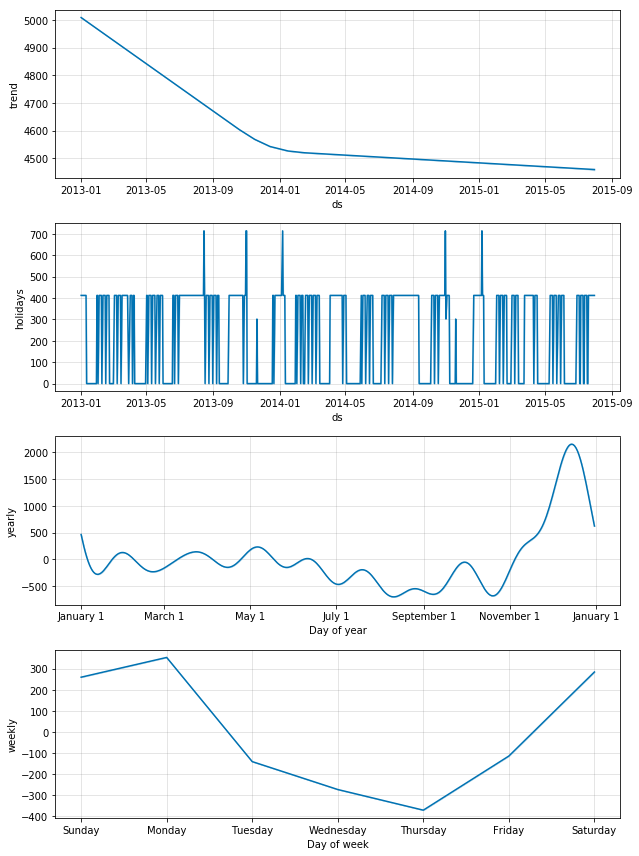

In [209]:
my_model.plot_components(forecast)
print('Component plot')

In [222]:
train_store[train_store.StoreType == 'd'].Store.unique()

array([  13,   15,   18,   20,   23,   26,   29,   31,   35,   38,   41,
         43,   45,   49,   50,   52,   54,   56,   57,   60,   64,   66,
         75,   76,   77,   80,   94,   97,   98,  100,  101,  103,  108,
        111,  113,  115,  118,  120,  126,  127,  128,  132,  135,  143,
        146,  147,  149,  151,  154,  155,  158,  159,  160,  162,  169,
        178,  180,  182,  184,  185,  188,  189,  192,  194,  199,  201,
        202,  210,  213,  214,  215,  221,  223,  224,  225,  228,  229,
        230,  231,  234,  239,  241,  242,  244,  247,  249,  250,  252,
        254,  261,  275,  277,  279,  280,  281,  284,  288,  289,  291,
        298,  299,  302,  309,  312,  313,  316,  317,  318,  323,  326,
        334,  337,  342,  343,  347,  350,  352,  354,  356,  359,  366,
        367,  368,  369,  370,  371,  372,  373,  379,  385,  386,  393,
        394,  406,  409,  411,  412,  414,  415,  420,  424,  425,  428,
        429,  430,  431,  436,  438,  440,  441,  4